This notebook has been designed to work both on Google Colab as well as offline (assuming that you have all the required libraries!).<br/>
<font color='firebrick'>**NOTE: Set the USE_COLLAB=True if cell below if running notebook on Google Collaboratory. </font><font color='steelblue'>Set USE_COLLAB=False if running 'offline'.</font>** Setting flag to True maps your Google Drive into the Colaboratory workspace allowing you to read files from and save files to your Google Drive.<br/>
[See this link](https://medium.com/lean-in-women-in-tech-india/google-colab-the-beginners-guide-5ad3b417dfa) for a quick intro to using Google Colab, which provides a free GPU and connections to Kaggle, Github and your Google drive :)!

In [0]:
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLLAB = True

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization & display a message telling you to which folder
    # your Google Drive is mapped to
    drive.mount('/content/drive/')
    print('Your notebooks on Google Drive available at /content/drive/My Drive/Colab Notebooks/')
    
    # display list of files
    #!ls '/content/drive/My Drive/Colab Notebooks/kr_helper_funcs.py'
    
    # append our Google Drive folder to module search 
    # **NOTE:** comment this line out if you are NOT running this notebook on Google Colab
    import sys
    sys.path.append("/content/drive/My Drive/Colab Notebooks/")
    # and test it
    import kr_helper_funcs as kru
    MODEL_SAVE_DIR = "/content/drive/My Drive/Colab Notebooks/model_states"
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    
import os
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
Your notebooks on Google Drive available at /content/drive/My Drive/Colab Notebooks/


# <center>FASHION - Multiclass Classification With CNN<br/> (using Keras)</center>
<center>![Keras Logo](https://drive.google.com/uc?id=1Xvh0D0GFOFuk28lxGrsiUOexBMbjrTXo)</center>

In this notebook, we will illustrate multi-class classification for the **Fashion-MNIST dataset** using Convolution Neural Networks (CNN). Fashion-MNIST can be used as drop-in replacement for the original MNIST dataset (of 10 categories of handwritten digits). It shares the same image size (28x28 graysacle) and has 60,000 training and 10,000 testing splits. However, unlike the 'simple' number images, the images from this dataset are a bit involved. So, our CNN network architecture will be different.

Per [Zolando](https://github.com/zalandoresearch/fashion-mnist), the Fashion-MNIST dataset was created as a replacement for the MNIST dataset because:
* **MNIST is too easy**. Convolutional nets can achieve 99.7% on MNIST. Classic machine learning algorithms can also achieve 97% easily. 
* **MNIST is overused**. 
* **MNIST cannot represent modern CV tasks**
Take a look at the link above and read the various articles it references.

We have 10 categories of output labels - unlike the MNIST dataset, where they were values for numbers, we have distinct types here.

Label Description 
* 0 - T-shirt/top 
* 1 - Trouser 
* 2 - Pullover 
* 3 - Dress 
* 4 - Coat 
* 5 - Sandal 
* 6 - Shirt 
* 7 - Sneaker 
* 8 - Bag 
* 9 - Ankle boot

In [0]:
import warnings
warnings.filterwarnings("ignore")

import os, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

float_formatter = lambda x: '%.4f' % x
np.set_printoptions(formatter={'float_kind':float_formatter})
np.set_printoptions(threshold=np.inf, suppress=True, precision=4)

plt.style.use("seaborn-colorblind")
plt.rcParams["figure.figsize"] = (8, 6)
sns.set_style("darkgrid")
#sns.set_context("talk")
sns.set_context(context='notebook', font_scale=1.25)
sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

# NOTE: It is important that you set a seed value to get same results in every run.
# Any number is Ok.
seed = 123
random.seed(seed)
np.random.seed(seed)

## Loading & Preprocessing the Dataset

I am going to load the Fashion-MNIST dataset from the `keras.datasets` library. We'll use the `keras.datasets.fashion_mnist.load_data()`call. The dataset is downloaded the very first time you call it. The function conveniently returns two tuples of data & labels. The images are not normalized - this is something we will handle.

In [0]:
def load_and_preprocess_data(std_normalize=False, debug=False):
    from keras.datasets.fashion_mnist import load_data
    from keras.utils import to_categorical

    (X_train, y_train), (X_test, y_test) = load_data()

    if debug:
        print('Before preprocessing:')
        print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
        print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))

    # per Andrew Ng's advise in his Structured ML coure (on deeplearning.ai), the test & cross-validation 
    # datasets must come from the same distribution!
    # So, we are going to split X_test/y_test into cross-validation & test datasets.
    # We have 10,000 samples in X_test/y_test - we will assign 6,000 to X_val/y_val & 4,000 remaining
    # examples to X_test/y_test (test dataset) AFTER randomly sorting the dataset

    # randomly shuffle the datasets to get rid of any kind of implicit sorting
    indexes = np.arange(X_test.shape[0])
    indexes = np.random.permutation(indexes)  # shuffle data to randomly select
    X_test = X_test[indexes]
    y_test = y_test[indexes]
    
    indexes = np.arange(X_train.shape[0])
    indexes = np.random.permutation(indexes)  # shuffle data to randomly select
    X_train = X_train[indexes]
    y_train = y_train[indexes]    
    
    # 'split' into cross-val & test sets (use 8000 records in cross-val & 2000 in test set)    
    val_count = 8000
    X_val = X_test[:val_count]
    y_val = y_test[:val_count]
    X_test = X_test[val_count:]
    y_test = y_test[val_count:]

    # keep an non pre-processed copy of X_test/y_test for visualization
    test_images, test_labels = X_test.copy(), y_test.copy()
    
    if std_normalize:
        # standard-scale the images (works on GPU - may hang on CPU!!)
        epsilon = 1e-7  # to avoid divide by zero errors (if any)
        X_train_mean = np.mean(X_train, axis=(0,1,2,3))
        X_train_std = np.std(X_train, axis=(0,1,2,3))
        X_train = (X_train - X_train_mean) / (X_train_std + epsilon)
        X_val = (X_val - X_train_mean) / (X_train_std + epsilon)
        X_test = (X_test - X_train_mean) / (X_train_std + epsilon)
    else:
        # scale the images to between 0-1
        X_train = X_train.astype('float32') / 255.0
        X_val = X_val.astype('float32') / 255.0
        X_test = X_test.astype('float32') / 255.0
    
    # one-hot encode labels to 10 output classes corresponding to digits 0-9
    y_train = to_categorical(y_train, 10)
    y_val = to_categorical(y_val, 10)
    y_test = to_categorical(y_test, 10)

    # reshape the image arrays (make 2D arrays instead of 3D arrays)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

    if debug:
        print('After preprocessing:')
        print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
        print(' - X_val.shape = {}, y_val.shape = {}'.format(X_val.shape, y_val.shape))
        print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))
        print(' - test_images.shape = {}, test_labels.shape = {}'.format(test_images.shape,
            test_labels.shape))

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), (test_images, test_labels)

In [0]:
def display_sample(sample_images, sample_labels, sample_predictions=None, num_rows=5, num_cols=10,
                   plot_title=None, fig_size=None):
    """ display a random selection of images & corresponding labels, optionally with predictions
        The display is laid out in a grid of num_rows x num_col cells
        If sample_predictions are provided, then each cell's title displays the prediction (if it matches
        actual)
        or actual/prediction if there is a mismatch
    """
    assert sample_images.shape[0] == num_rows * num_cols

    # a dict to help encode/decode the labels
    FASHION_LABELS = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot',
    }

    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=((14, 9) if fig_size is None else fig_size),
            gridspec_kw={"wspace": 0.02, "hspace": 0.30}, squeeze=True)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                ax[r, c].imshow(sample_images[image_index], cmap="Greys")

                if sample_predictions is None:
                    # show the actual labels in the cell title
                    title = ax[r, c].set_title("%s" % FASHION_LABELS[sample_labels[image_index]])
                else:
                    # else check if prediction matches actual value
                    true_label = sample_labels[image_index]
                    pred_label = sample_predictions[image_index]
                    prediction_matches_true = (sample_labels[image_index] == sample_predictions[image_index])
                    if prediction_matches_true:
                        # if actual == prediction, cell title is prediction shown in green font
                        title = FASHION_LABELS[true_label]
                        title_color = 'g'
                    else:
                        # if actual != prediction, cell title is actua/prediction in red font
                        title = '%s/%s' % (FASHION_LABELS[true_label], FASHION_LABELS[pred_label])
                        title_color = 'r'
                    # display cell title
                    title = ax[r, c].set_title(title)
                    plt.setp(title, color=title_color)
        # set plot title, if one specified
        if plot_title is not None:
            f.suptitle(plot_title)

        plt.show()
        plt.close()

In [0]:
# load & pre-process our dataset
(X_train, y_train), (X_val, y_val), (X_test, y_test), (test_images, test_labels) = \
    load_and_preprocess_data(debug=True)

Using TensorFlow backend.


4423680/4422102 [==============================] - 0s 0us/step
Before preprocessing:
 - X_train.shape = (60000, 28, 28), y_train.shape = (60000,)
 - X_test.shape = (10000, 28, 28), y_test.shape = (10000,)
After preprocessing:
 - X_train.shape = (60000, 28, 28, 1), y_train.shape = (60000, 10)
 - X_val.shape = (8000, 28, 28, 1), y_val.shape = (8000, 10)
 - X_test.shape = (2000, 28, 28, 1), y_test.shape = (2000, 10)
 - test_images.shape = (2000, 28, 28), test_labels.shape = (2000,)


Notice the following:
* **Before Pre-processing**:
    * We have 60,000 images in the training set & 10,000 images in the test set. 
    * They have shapes of `(60000,28,28)` and `(10000,28,28)` respectively. 
* **After pre-processing**: 
    * The training dataset retains it's 60,000 images 
    * The test dataset has been split into a cross-validation dataset (X_val/y_val) with 6,000 records and a test set (X_test/y_test) with 4,000 record
    * We have reshaped all the feature (X's) datasets into 3D tensors
    * We have one-hot encoded all the label datasets to 10 classes

Let us randomly select 50 images from the test dataset and see how they look - we will display the images in a 5x10 grid below.

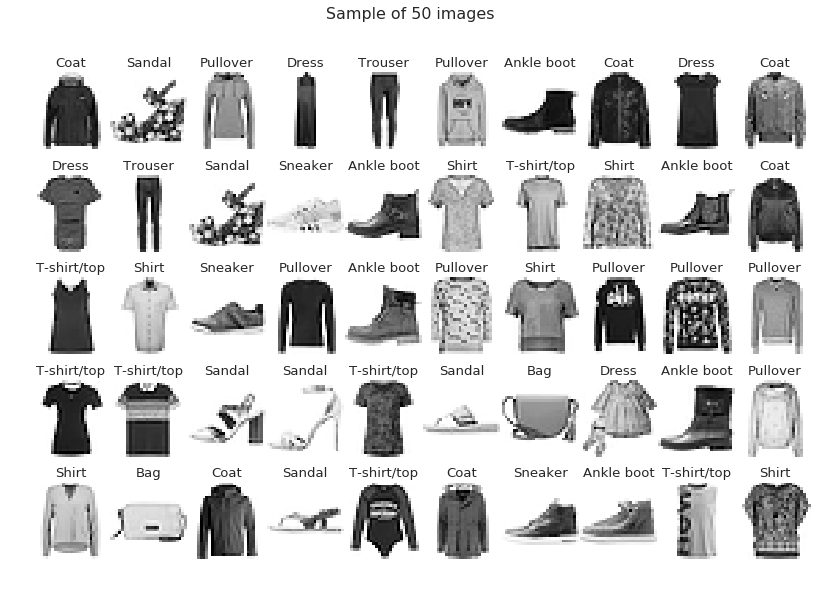

In [0]:
sample_size = 50
rand_indexes = np.random.randint(0, len(X_test), sample_size)
sample_images = test_images[rand_indexes]
sample_labels = test_labels[rand_indexes]
display_sample(sample_images, sample_labels, plot_title='Sample of %d images' % sample_size)

## Keras Model Development

This section includes the following functions:
* `train_and_evaluate_model()` - trains model on training dataset & evaluates performance on the cross-validation dataset. Saves model to a file name on disk (Google Drive if running in Colab or directory on disk)
* `do_predictions()` - loads model state from disk and tests it on test dataset and plots predictions on a random sample of non-preprocessed data from the test set.

In [0]:
import keras.backend as K
from tensorflow import set_random_seed
from keras.layers import (Input, Dense, Dropout, Conv2D, MaxPooling2D, Activation,
                          BatchNormalization, Flatten)
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import kr_helper_funcs as kru

set_random_seed(seed)  # seed the Tensorflow backend!
K.clear_session()   # start afresh each time!!

In [0]:
# some globals
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 28, 28, 1, 10

In [0]:
# cross-train model & evaluate performance on train & cross-validation data
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, 
                             num_epochs=25, batch_size=32, plot_title=None, 
                             model_save_name=None, callbacks=None, use_data_aug=False):
    """
    cross train & evaluate model's performance on training, cross-val & test datasets
    @params:
        - X_train/y_train: pre-processed training datasets
        - X_val/y_val: pre-processed cross-validation datasets
        - epochs (optional, default=25) - no of epochs for which training should be done
        - batch_size (optional, default=32) - the batch size to use for mini-batch gradient descent training
        - plot_title (optional, default=None) - plots loss vs epochs and accuracy vs epoch curves if assigned value
            other than None. Uses this assigned value as the plot's title
        - model_save_name (optional, default=None) - the file name to which the Keras model is saved to - if value 
            other than None is specified, then the Keras model's state is saved to this file name (NOTE: this is saved
            in the './keras_models/model_save_name' file)
        - callbacks (optional, default=None) a list of callbacks to apply during training
        - use_data_aug (optional, default=False) - if true, use data augmentation to generate additional training images
    """
    # we will add the following callbacks by default. If user provides callbacks, then
    # we will use those INSTEAD of these
    callbacks_list_default = [
        # reduce learning rate by a factor of 5 (i.e. lr/=5.0) 
        # if val_loss does not reduce for 3 epochs
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3
        ),
        # Stop training if val_acc does not improve for
        # 5 or more epochs
        EarlyStopping(
            monitor='val_acc',
            patience=5        
        )
    ]
    
    # if user provides her own callbacks, use them instead of our list
    callbacks2use = (callbacks_list_default if callbacks is None else callbacks)
    
    if use_data_aug:
        print('Training mode with data augmentation...', flush=True)
        # use image augmentation to increase training images
        
        from keras.preprocessing.image import ImageDataGenerator

        # NOTE: our datasets have already been scaled 
        train_datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.3,
            zoom_range=(0.9, 1.1),
            horizontal_flip=False,
            vertical_flip=False, 
            fill_mode='constant',
            cval=0)

        #train_datagen.fit(X_train)

        # fit the data generator on training data & validate on
        num_batches = len(X_train) // batch_size
        num_batches += (0 if len(X_train) % batch_size == 0 else 1)     
        
        history = model.fit_generator(train_datagen.flow(X_train, y_train, 
                                                         batch_size=batch_size),
                                      steps_per_epoch = num_batches, 
                                      epochs = num_epochs,
                                      callbacks = callbacks2use,
                                      validation_data = (X_val, y_val))        
    else:
        # train on X_train/y_train & cross-validate on X_val/y_val
        history = model.fit(X_train, y_train, epochs=num_epochs,
                            batch_size = batch_size, validation_data = (X_val, y_val), 
                            callbacks = callbacks2use)
    
    
    if plot_title is not None:
        kru.show_plots(history.history, plot_title=plot_title)

    # evaluate metrics
    print("\nEvaluating...", flush=True)
    print('Training data:', flush=True)
    loss, acc = model.evaluate(X_train, y_train, verbose=1)
    print("  Training : loss %.3f - acc %.3f" % (loss, acc))
    
    print('Cross-validation data:', flush=True)
    loss, acc = model.evaluate(X_val, y_val, verbose=1)
    print("  Cross-val: loss %.3f - acc %.3f" % (loss, acc))
        
    if model_save_name is not None:
        kru.save_keras_model(model, model_save_name, MODEL_SAVE_DIR)

In [0]:
def do_predictions(model_save_name, X_test, y_test, test_images, test_labels, plot_title=None):
    def test_model(model, X_test, y_test, test_images, test_labels, plot_title=None):
        print('Evaluating against test data...', flush=True)
        loss, acc = model.evaluate(X_test, y_test)
        print('  - Test data: loss %.3f - acc %.3f' % (loss, acc))

        print('Displaying sample predictions...', flush=True)
        # run predictions
        y_pred = model.predict(X_test)

        # test with 50 random images
        num_images = 50
        rand_indexes = np.random.randint(0, len(X_test), num_images)
        sample_images = test_images[rand_indexes]
        sample_labels = test_labels[rand_indexes]
        sample_predictions = np.argmax(y_pred[rand_indexes], axis=1)

        display_sample(sample_images, sample_labels, sample_predictions,
            num_rows=5, num_cols=10, plot_title=plot_title)
    
    # load the model from saved state
    model = kru.load_keras_model(model_save_name, MODEL_SAVE_DIR)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    test_model(model, X_test, y_test, test_images, test_labels, plot_title=plot_title)
    del model

# Model Development

In this section, we cross-train various configurations of the model on `(X_train, y_train)` and `(X_val, y_val)` and record the performance. The model we will use is created in the `build_model()` function below. The following _configurations_ are trained and evaluated:
>Configuration|
>:---|
>**Base Model** (no regularization)| 
>**Base Model + L2 Regularization**|
>**Base Model + Dropout Regularization**|
>**Base Model + L2 Regularization + Dropout Regularization**|

Finally, the best performing model from the above configurations trained with image augmentation to check if better performance can be squeezed out of the model.

In [0]:
def build_model(use_l2_reg=False, use_dropout=False, lr=0.0001, 
                l2_loss_lambda=0.0015):
    K.clear_session()
    
    """
    build Keras model, optionally adding l2-regularization or dropout regularization or both
    @params:
        - use_l2_reg (optional, default=False): build model with l2 reg, if True
        - use_dropout (optional, default=False): build model with dropout reg, if True
        - lr (optional, default=0.0001): learning rate of Adam optimizer used.
        - l2_loss_lambda (optional, default=0.0015): L2 loss lambda to use
    """ 
    
    # l2 regularization - very small as we are applying to 'heavy' Conv2D layers
    assert l2_loss_lambda is not None
    
    l2 = regularizers.l2(l2_loss_lambda) if use_l2_reg else None
    # printing this as we cannot 'visualize' L2 Normalization applied to a layer
    if l2 is not None: print('Using L2 regularization %.6f' % l2_loss_lambda)
    
    # we will use the Keras functional API to build the model
    inputs = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
    
    x = Conv2D(32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2)(inputs)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    if use_dropout: x = Dropout(0.15)(x)
    
    x = Conv2D(64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    if use_dropout: x = Dropout(0.2)(x)    

    x = Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2)(x)
    x = Activation('relu')(x)     
    x = MaxPooling2D(pool_size=(2,2))(x)
    if use_dropout: x = Dropout(0.3)(x)            

    x = Flatten()(x)
    if use_dropout: x = Dropout(0.4)(x)
    
    x = Dense(1024, activation='relu', kernel_regularizer=l2)(x)
    if use_dropout: x = Dropout(0.4)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2)(x)
    if use_dropout: x = Dropout(0.2)(x)
    
    out = Dense(units=NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=out)
    adam = Adam(lr=lr) #, decay=1e-6)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [0]:
def plot_model(model, file_name):
    from keras.utils import plot_model
    from IPython.display import Image, display
    
    try:
        # if required libraries are not setup properly, the plot_model(...) call
        # below will throw an exception. If so, we display text summary
        image_path = os.path.join(MODEL_SAVE_DIR, file_name + '.png')
        plot_model(model, show_shapes=True, show_layer_names=True, to_file=image_path)
        display(Image(image_path))
    except:
        print('Warning! Can\'t display model structure graphically. Displaying summary instead')
        print(model.summary())

## Training Base Model

Training model without any regularization - no Batch Normalization, no L2 regularization and no Dropout regularization

In [0]:
# we will use sligtly more lenient callbacks for early stopping
# making the default callbacks slighly more lenient
callbacks_list2 = [
    # reduce learning rate by a factor of 10 of val_loss 
    # does not reduce for 3 epochs
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=4,
        min_lr=0.00000001
    ),
    # Early stop training if val_acc falls or stays flat for 7 epochs
    EarlyStopping(
        monitor='val_acc',
        min_delta=0.00001,
        patience=7        
    ),
]

In [0]:
model = build_model()
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 8000 samples
Epoch 1/50
60000/60000 [==============================] - 16s 268us/step - loss: 0.5737 - acc: 0.7923 - val_loss: 0.4239 - val_acc: 0.8485
Epoch 2/50
60000/60000 [==============================] - 11s 181us/step - loss: 0.3616 - acc: 0.8696 - val_loss: 0.3604 - val_acc: 0.8674
Epoch 3/50
60000/60000 [==============================] - 11s 179us/step - loss: 0.3087 - acc: 0.8870 - val_loss: 0.3030 - val_acc: 0.8882
Epoch 4/50
60000/60000 [==============================] - 11s 180us/step - loss: 0.2757 - acc: 0.8990 - val_loss: 0.2841 - val_acc: 0.8970
Epoch 5/50
60000/60000 [==============================] - 11s 186us/step - loss: 0.2509 - acc: 0.9084 - val_loss: 0.2838 - val_acc: 0.8982
Epoch 6/50
60000/60000 [==============================] - 11s 180us/step - loss: 0.2321 - acc: 0.9157 - val_loss: 0.2581 - val_acc: 0.9022
Epoch 7/50
60000/60000 [==============================] - 11s 181us/s

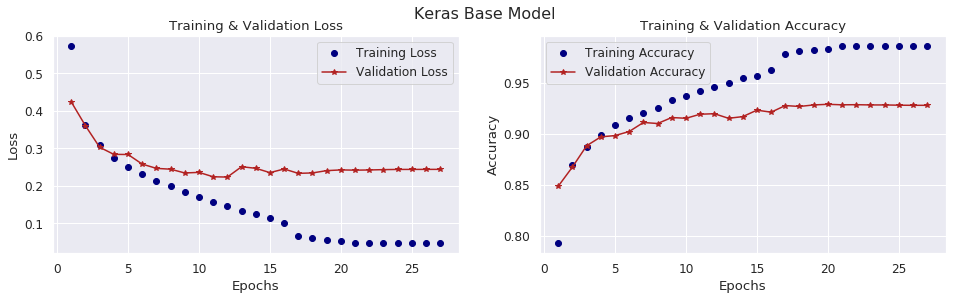


Evaluating...
Training data:
60000/60000 [==============================] - 3s 50us/step
  Training : loss 0.047 - acc 0.987
Cross-validation data:
8000/8000 [==============================] - 0s 52us/step
  Cross-val: loss 0.244 - acc 0.928
Saved model to files /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_base.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_base.h5


In [0]:
model_name = 'kr_fashion_cnn_base'
plot_title = 'Keras Base Model'
train_and_evaluate_model(model, X_train, y_train, X_val, y_val, 
                         num_epochs=50, batch_size=32, callbacks=callbacks_list2,
                         plot_title=plot_title, model_save_name=model_name)
del model # we will load model from saved state to make predictions (as shown in next cell)

Loaded model from files /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_base.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_base.h5
Evaluating against test data...
2000/2000 [==============================] - 0s 111us/step
  - Test data: loss 0.288 - acc 0.917
Displaying sample predictions...


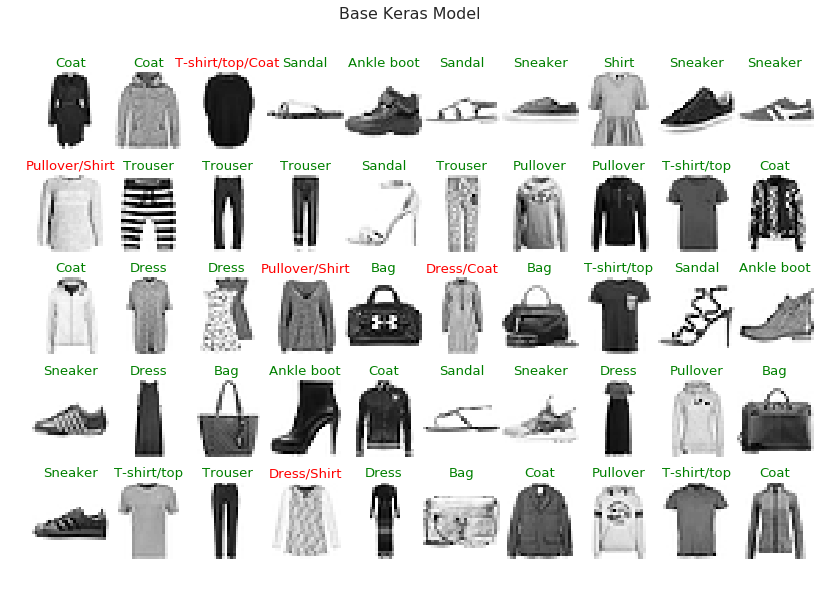

In [0]:
do_predictions('kr_fashion_cnn_base', X_test, y_test, test_images, test_labels, plot_title='Base Keras Model')

### Observation from training base model:
See [this Colab Notebook](https://colab.research.google.com/drive/1brSHFOnPQTo0-9vQRC6oslZjAGRbzWuY) for _examples on inserting tables inside markdown cells_
>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|98-99%|92-93%|92-93%

* Model is overfitting - observe the large difference between training & cross-validation accuracies. From plots we observe overfitting after 10-12 epochs.

## Using L2 Regularization with Base Model
In this section we will add L2 Regularization to the base model. A L2 regularizer applies penalties on layer parameters (= L2 Norm of weights) during optimization. These penalties are incorporated in the loss function that the network optimizes. Higher weights/parameters tend to get penalized more, so we end up with simpler models that overfit less. <br/>
L2 Regularization can be added to any Keras `Conv2D` or `Dense` layer by setting the `kernel_regularizer` parameter to an appropriate value. We use `kernel_regularizer = regularizers.l2(0.0015)` by default. L2 regularization is applied if you set `use_l2_reg=True` in the `build_model()` function. The penalty applied (0.0015, by default) can be changed by passing your value in the `l2_loss_lambda` parameter of `build_model()` function.

In [0]:
model = build_model(use_l2_reg=True) # 'add' L2 regularization to base model
print(model.summary())

Using L2 regularization 0.001500
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 6

Train on 60000 samples, validate on 8000 samples
Epoch 1/100
60000/60000 [==============================] - 12s 199us/step - loss: 1.8229 - acc: 0.7782 - val_loss: 1.2631 - val_acc: 0.8350
Epoch 2/100
60000/60000 [==============================] - 12s 192us/step - loss: 1.0457 - acc: 0.8578 - val_loss: 0.8842 - val_acc: 0.8666
Epoch 3/100
60000/60000 [==============================] - 11s 191us/step - loss: 0.7765 - acc: 0.8731 - val_loss: 0.7008 - val_acc: 0.8740
Epoch 4/100
60000/60000 [==============================] - 11s 184us/step - loss: 0.6299 - acc: 0.8809 - val_loss: 0.5836 - val_acc: 0.8849
Epoch 5/100
60000/60000 [==============================] - 11s 187us/step - loss: 0.5471 - acc: 0.8862 - val_loss: 0.5280 - val_acc: 0.8856
Epoch 6/100
60000/60000 [==============================] - 12s 198us/step - loss: 0.4964 - acc: 0.8919 - val_loss: 0.5104 - val_acc: 0.8818
Epoch 7/100
60000/60000 [==============================] - 11s 185us/step - loss: 0.4633 - acc: 0.8950 - val_lo

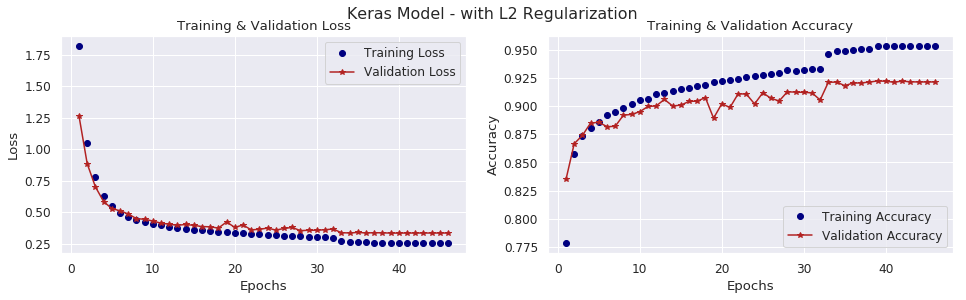


Evaluating...
Training data:
60000/60000 [==============================] - 3s 56us/step
  Training : loss 0.251 - acc 0.954
Cross-validation data:
8000/8000 [==============================] - 0s 56us/step
  Cross-val: loss 0.333 - acc 0.921
Saved model to files /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_l2_reg_2.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_l2_reg_2.h5


In [0]:
model_name = 'kr_fashion_cnn_l2_reg_2'
plot_title = 'Keras Model - with L2 Regularization'
train_and_evaluate_model(model, X_train, y_train, X_val, y_val, 
                         num_epochs=100, batch_size=32,  callbacks=callbacks_list2,
                         plot_title=plot_title, model_save_name=model_name)
del model # we will load model from saved state to make predictions (as shown in next cell)

Loaded model from files /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_l2_reg_2.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_l2_reg_2.h5
Evaluating against test data...
2000/2000 [==============================] - 0s 119us/step
  - Test data: loss 0.362 - acc 0.917
Displaying sample predictions...


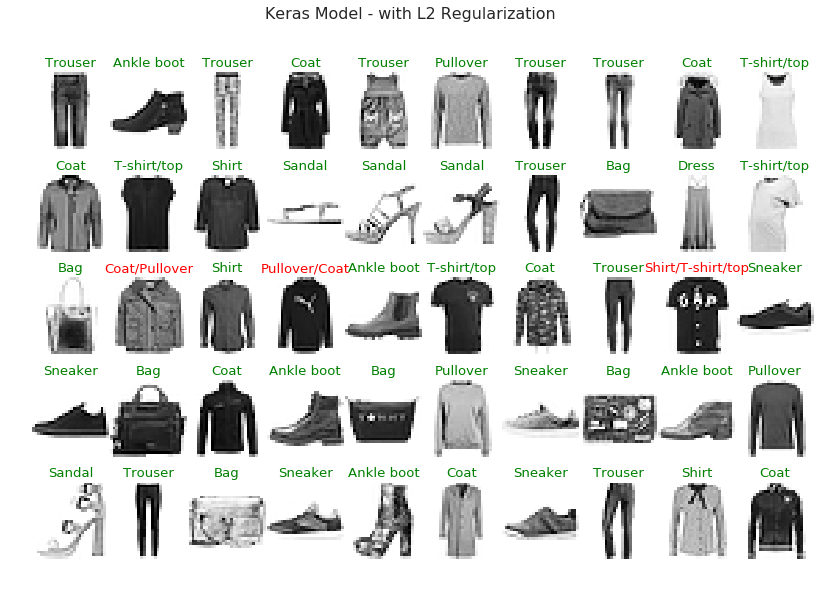

In [0]:
do_predictions('kr_fashion_cnn_l2_reg_2', X_test, y_test, test_images, test_labels, 
               plot_title='Keras Model - with L2 Regularization')

**Observations - model with L2 Regularization:**<br/>
See [this Colab Notebook](https://colab.research.google.com/drive/1brSHFOnPQTo0-9vQRC6oslZjAGRbzWuY) for _examples on inserting tables inside markdown cells_
>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|98-99%|92-93%|92-93%
>**Base Model + L2 Reg**|95-96%|92-93%|92-93%

* Adding L2 regularization had significantly reduced overfitting - training accuracy has come down to 95-96% from 99-100% levels of base model. 
* Cross-validation and test accuracies are at the same values as the base model - 92-93%.
* From the plots you see that overfitting is delayed by many more epochs - the cross-val loss & accuracy plots follow the training plots for many more epochs before digressing.

## Using Dropout Regularization with Base Model
In this section we will add _Dropout Regularization_ to the base model. Dropout regularization is applied to a layer by adding a  `Dropout()` layer after it. To this layer, you specify a certain percentage of nodes that must be randomly be dropped _during training_. (e.g. Dropout(0.3) drops 30% nodes from previous layer randomly _during training_). To enable dropout regularization to our model, set `use_dropout=True` in the `build_model()` function.

In [0]:
model = build_model(use_dropout=True)
print(model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
___________________________

Train on 60000 samples, validate on 8000 samples
Epoch 1/100
60000/60000 [==============================] - 12s 201us/step - loss: 0.9016 - acc: 0.6557 - val_loss: 0.5633 - val_acc: 0.7823
Epoch 2/100
60000/60000 [==============================] - 11s 191us/step - loss: 0.5748 - acc: 0.7856 - val_loss: 0.4636 - val_acc: 0.8280
Epoch 3/100
60000/60000 [==============================] - 11s 192us/step - loss: 0.4872 - acc: 0.8217 - val_loss: 0.3911 - val_acc: 0.8571
Epoch 4/100
60000/60000 [==============================] - 11s 191us/step - loss: 0.4316 - acc: 0.8420 - val_loss: 0.3595 - val_acc: 0.8664
Epoch 5/100
60000/60000 [==============================] - 12s 206us/step - loss: 0.3960 - acc: 0.8544 - val_loss: 0.3367 - val_acc: 0.8721
Epoch 6/100
60000/60000 [==============================] - 11s 191us/step - loss: 0.3738 - acc: 0.8616 - val_loss: 0.3148 - val_acc: 0.8828
Epoch 7/100
60000/60000 [==============================] - 11s 191us/step - loss: 0.3526 - acc: 0.8695 - val_lo

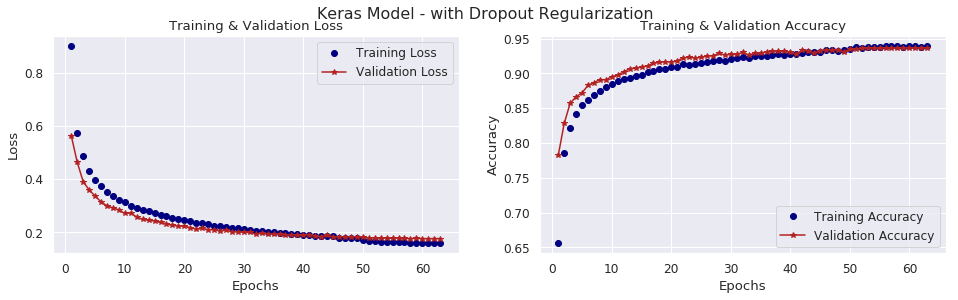


Evaluating...
Training data:
60000/60000 [==============================] - 3s 50us/step
  Training : loss 0.102 - acc 0.964
Cross-validation data:
8000/8000 [==============================] - 0s 54us/step
  Cross-val: loss 0.177 - acc 0.937
Saved model to files /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_do_reg_2.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_do_reg_2.h5


In [0]:
model_name = 'kr_fashion_cnn_do_reg_2'
plot_title = 'Keras Model - with Dropout Regularization'
train_and_evaluate_model(model, X_train, y_train, X_val, y_val, 
                         num_epochs=100, batch_size=32,  callbacks=callbacks_list2,
                         plot_title=plot_title, model_save_name=model_name)
del model # we will load model from saved state to make predictions (as shown in next cell)

Loaded model from files /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_do_reg_2.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_do_reg_2.h5
Evaluating against test data...
2000/2000 [==============================] - 0s 132us/step
  - Test data: loss 0.201 - acc 0.929
Displaying sample predictions...


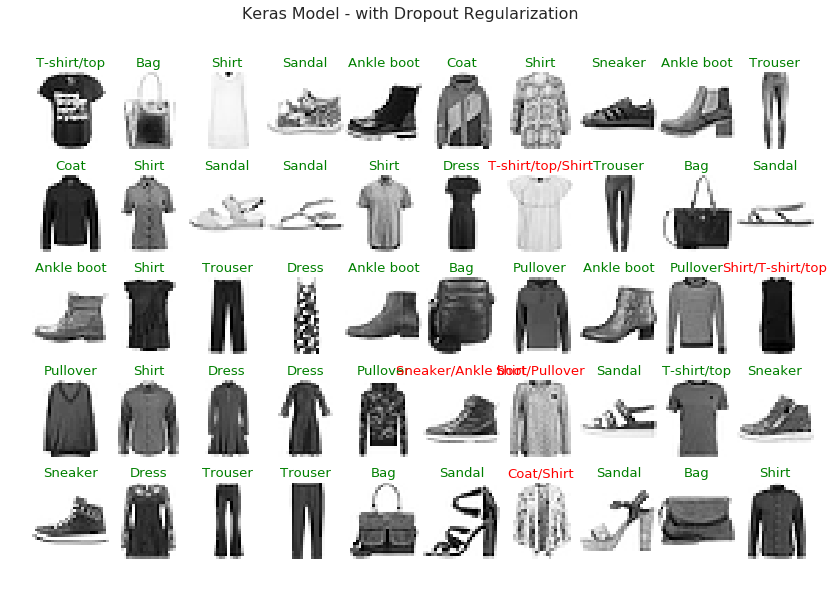

In [0]:
do_predictions('kr_fashion_cnn_do_reg_2', X_test, y_test, test_images, test_labels, 
               plot_title='Keras Model - with Dropout Regularization')

**Observation - model with Dropout Regularization:**<br/>
See [this Colab Notebook](https://colab.research.google.com/drive/1brSHFOnPQTo0-9vQRC6oslZjAGRbzWuY) for _examples on inserting tables inside markdown cells_
>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|98-99%|92-93%|92-93%
>**Base Model + L2 Reg**|95-96%|92-93%|92-93%
>**Base Model + Dropout Reg**|96-97%|93-94%|93-94%

* As with L2 regularization, adding dropout regularization had  reduced overfitting - training accuracy has come down to 96-97% from 99-100% levels observed with the base model (this is slightly more than with L2 regularization)
* Cross-validation & test accuracy is slightly better than that of the base model & model with L2 Regularization.
* From the plots you see that overfitting is delayed by many more epochs - the cross-val loss & accuracy plots follow the training plots for many more epochs.
* It is difficult to say which model - one with L2 regularization or one with Batch normalization is the better of the two. Just based on test-accuracy, I would pick the one with Dropout Regularization.


## Using both L2 Regularization and Dropout Regularization together
Let's enable both and see if we get better performance (i.e. lesser overfitting & equal-to-cross-validation-or-better test accuracy).<br/>
**NOTE:** Intuitively, I expect worse performance that model with just L2 or just Dropout applies (since overally regularization will increase!). Let's train & see by how much it decreases.

In [0]:
model = build_model(use_l2_reg=True, use_dropout=True)
print(model.summary())

Using L2 regularization 0.001500
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14,

Train on 60000 samples, validate on 8000 samples
Epoch 1/200
60000/60000 [==============================] - 13s 218us/step - loss: 2.8110 - acc: 0.6457 - val_loss: 1.9982 - val_acc: 0.7619
Epoch 2/200
60000/60000 [==============================] - 13s 209us/step - loss: 1.6791 - acc: 0.7736 - val_loss: 1.3116 - val_acc: 0.8143
Epoch 3/200
60000/60000 [==============================] - 13s 224us/step - loss: 1.1651 - acc: 0.8052 - val_loss: 0.9396 - val_acc: 0.8375
Epoch 4/200
60000/60000 [==============================] - 13s 212us/step - loss: 0.8943 - acc: 0.8254 - val_loss: 0.7503 - val_acc: 0.8501
Epoch 5/200
60000/60000 [==============================] - 12s 204us/step - loss: 0.7495 - acc: 0.8371 - val_loss: 0.6480 - val_acc: 0.8588
Epoch 6/200
60000/60000 [==============================] - 12s 204us/step - loss: 0.6690 - acc: 0.8443 - val_loss: 0.5954 - val_acc: 0.8646
Epoch 7/200
60000/60000 [==============================] - 12s 204us/step - loss: 0.6219 - acc: 0.8506 - val_lo

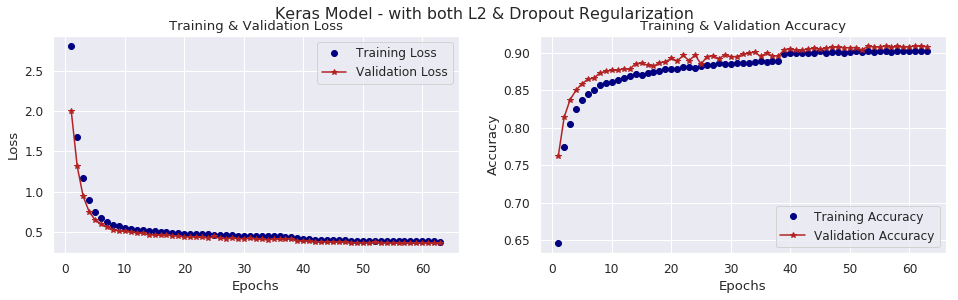


Evaluating...
Training data:
60000/60000 [==============================] - 3s 58us/step
  Training : loss 0.323 - acc 0.924
Cross-validation data:
8000/8000 [==============================] - 0s 59us/step
  Cross-val: loss 0.355 - acc 0.908
Saved model to files /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_do_l2_reg_2.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_do_l2_reg_2.h5


In [0]:
model_name = 'kr_fashion_cnn_do_l2_reg_2'
plot_title = 'Keras Model - with both L2 & Dropout Regularization'
train_and_evaluate_model(model, X_train, y_train, X_val, y_val, 
                         num_epochs=200, batch_size=32, callbacks=callbacks_list2,
                         plot_title=plot_title, model_save_name=model_name)
del model # we will load model from saved state to make predictions (as shown in next cell)

Loaded model from files /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_do_l2_reg_2.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_do_l2_reg_2.h5
Evaluating against test data...
2000/2000 [==============================] - 0s 153us/step
  - Test data: loss 0.385 - acc 0.902
Displaying sample predictions...


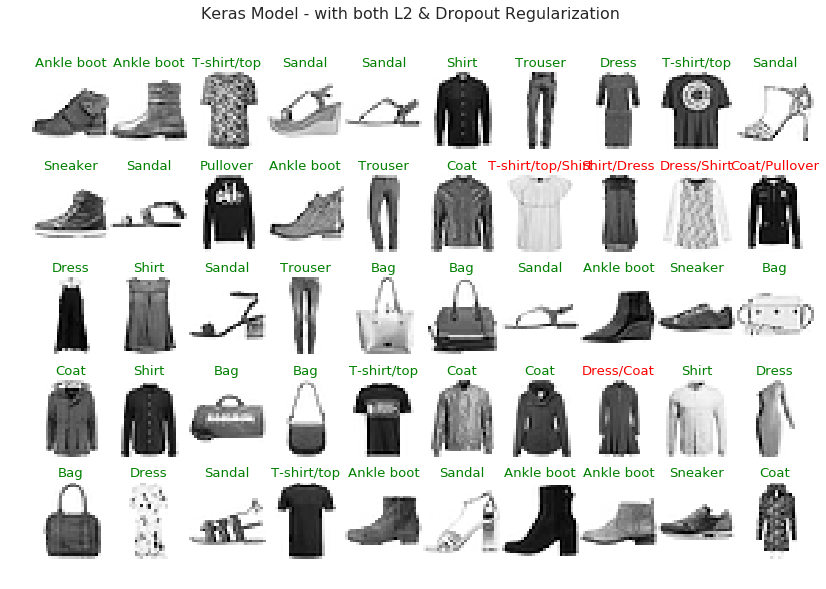

In [0]:
do_predictions('kr_fashion_cnn_do_l2_reg_2', X_test, y_test, test_images, test_labels, 
               plot_title='Keras Model - with both L2 & Dropout Regularization')

**Observations & Conclusion:**<br/>
See [this Colab Notebook](https://colab.research.google.com/drive/1brSHFOnPQTo0-9vQRC6oslZjAGRbzWuY) for _examples on inserting tables inside markdown cells_
>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|98-99%|92-93%|92-93%
>**Base Model + L2 Reg**|95-96%|92-93%|92-93%
>**Base Model + Dropout Reg**|96-97%|93-94%|93-94%
>**Base Model + L2 Reg + Dropout Reg (0.0015)**|92-93%|90-91%|90-91%

* **Conclusion:** Using both L2 regularization & Dropout regularization gives worse performance than using just L2 or just dropout regularization. 
* Perhaps our combination of L2 regularization & dropout regularization was _too aggressive_ for this model's architecture. We may want to _simplify_ by reducing the values used.


In [0]:
model = build_model(use_l2_reg=True, use_dropout=True, l2_loss_lambda=0.00020) # use slightly less l2-reg
print(model.summary())

Using L2 regularization 0.000200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14,

Train on 60000 samples, validate on 8000 samples
Epoch 1/200
60000/60000 [==============================] - 28s 464us/step - loss: 1.2375 - acc: 0.6650 - val_loss: 0.8974 - val_acc: 0.7800
Epoch 2/200
60000/60000 [==============================] - 27s 450us/step - loss: 0.8943 - acc: 0.7853 - val_loss: 0.7558 - val_acc: 0.8306
Epoch 3/200
60000/60000 [==============================] - 26s 436us/step - loss: 0.7752 - acc: 0.8193 - val_loss: 0.6639 - val_acc: 0.8526
Epoch 4/200
60000/60000 [==============================] - 27s 443us/step - loss: 0.6908 - acc: 0.8421 - val_loss: 0.6032 - val_acc: 0.8656
Epoch 5/200
60000/60000 [==============================] - 26s 439us/step - loss: 0.6279 - acc: 0.8532 - val_loss: 0.5553 - val_acc: 0.8742
Epoch 6/200
60000/60000 [==============================] - 27s 443us/step - loss: 0.5786 - acc: 0.8619 - val_loss: 0.5109 - val_acc: 0.8805
Epoch 7/200
60000/60000 [==============================] - 27s 453us/step - loss: 0.5406 - acc: 0.8683 - val_lo

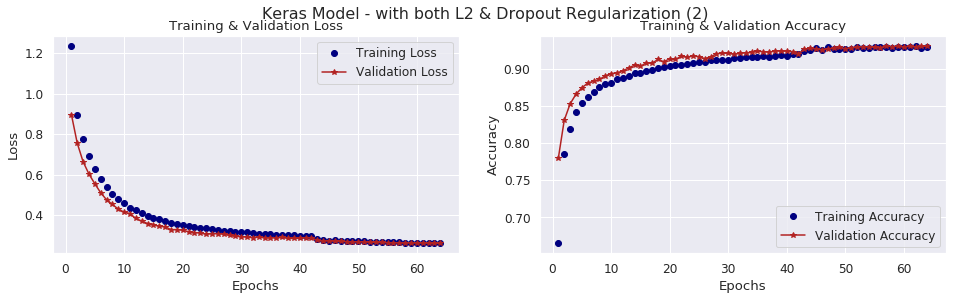


Evaluating...
Training data:
60000/60000 [==============================] - 8s 136us/step
  Training : loss 0.207 - acc 0.951
Cross-validation data:
8000/8000 [==============================] - 1s 131us/step
  Cross-val: loss 0.261 - acc 0.930
Saved model to files /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_do_l2_reg_2_2.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_do_l2_reg_2_2.h5


In [0]:
model_name = 'kr_fashion_cnn_do_l2_reg_2_2'
plot_title = plot_title='Keras Model - with both L2 & Dropout Regularization (2)'
train_and_evaluate_model(model, X_train, y_train, X_val, y_val, 
                         num_epochs=200, batch_size=32, callbacks=callbacks_list2,
                         plot_title=plot_title, model_save_name=model_name)
del model # we will load model from saved state to make predictions (as shown in next cell)

Loaded model from files /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_do_l2_reg_2_2.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_do_l2_reg_2_2.h5
Evaluating against test data...
2000/2000 [==============================] - 1s 485us/step
  - Test data: loss 0.289 - acc 0.921
Displaying sample predictions...


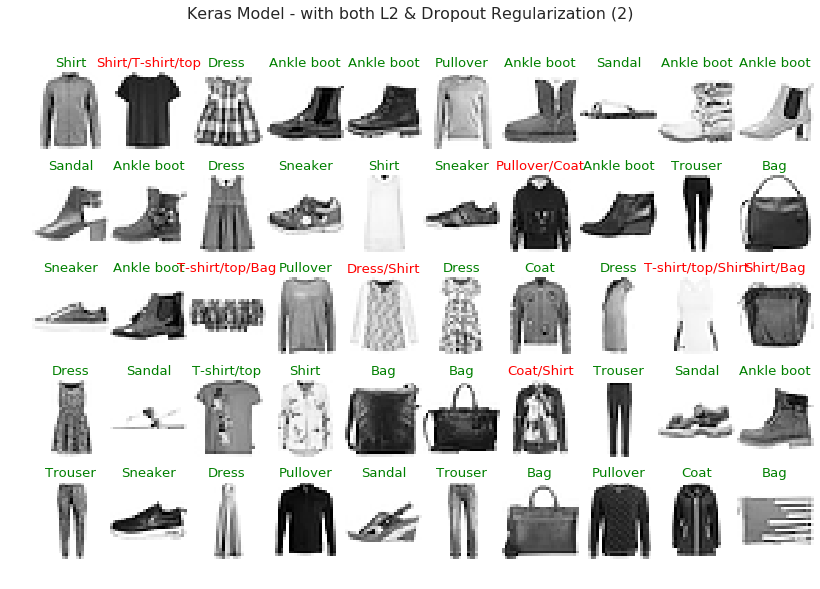

In [0]:
do_predictions('kr_fashion_cnn_do_l2_reg_2_2', X_test, y_test, test_images, test_labels, 
               plot_title='Keras Model - with both L2 & Dropout Regularization (2)')

**Observations & Conclusion:**<br/>
See [this Colab Notebook](https://colab.research.google.com/drive/1brSHFOnPQTo0-9vQRC6oslZjAGRbzWuY) for _examples on inserting tables inside markdown cells_
>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|98-99%|92-93%|92-93%
>**Base Model + L2 Reg**|95-96%|92-93%|92-93%
>**Base Model + Dropout Reg**|96-97%|93-94%|93-94%
>**Base Model + L2 Reg + Dropout Reg (0.0015)**|92-93%|90-91%|90-91%
>**Base Model + L2 Reg + Dropout Reg - 2 (0.00025)**|95-96%|93-94%|92-93%
>**Base Model + L2 Reg + Dropout Reg - 3 (0.00015)**|95-96%|93-94%|92-93%

* **Conclusion:** Using a smaller `l2_loss_lambda` is improving the performance of the model. However, note that performance seems to be tending towards the performance we get by using just Dropout Regularization! (Hah!)
* So, I finally conclude that with this model architecture, I get best performance using just Dropout Regularization - changing model architecture may give different performance metrics.

## Using Image Augmentation
**As things stand, the model that gives the best performance appears to be model using just Dropout regularization**. Notice that with all configurations we tried, though we were able to reduce overfitting to various degrees, our models could not achieve > 93-94% accuracy on test data. One of the disadvantages of deep models is that they require huge quantities of data to train. To give the model more training data, we could:
* Gather more images - impractical & time consuming
* Use image augmentation, which is a technique of artifically increasing training data size & variability by applying several random transformations to images. This is a practical approach and one we will try next.

Since the **base model + dropout reg** gave us the best performance, we will use that model with Image augmentation. We have already included the code in for adding image augmentation in our  `train_and_evaluate_model()` function - we just need to set `use_data_aug=True` when calling the function! For fun, I will use an even more lenient callbacks list, so that training is not Early Stopped.

<font color='firebrick'>**NOTE**: Don't try this on a CPU only machine - it will be a never ending experience! Google Colaboratory offers a free GPU. Use it if you don't have access to a GPU :)</font>

In [0]:
model = build_model(use_dropout=True) # this appears to be the best performing model
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)    

In [0]:
def train_and_evaluate_model_aug(model, X_train, y_train, X_val, y_val, 
                                 num_epochs=25, batch_size=32, plot_title=None, 
                                 callbacks=None,
                                 model_save_name=None):
    
    from keras.preprocessing.image import ImageDataGenerator
    
    train_datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.5,
        zoom_range=(0.9, 1.1),
        horizontal_flip=False,
        vertical_flip=False, 
        fill_mode='constant',
        cval=0)
    #train_datagen.fit(X_train)

    # fit the data generator on training data & validate on
    num_batches = len(X_train) // batch_size
    num_batches += (0 if len(X_train) % batch_size == 0 else 1)     

    history = model.fit_generator(train_datagen.flow(X_train, y_train, 
                                                     batch_size=batch_size,seed=seed),
                                  steps_per_epoch = num_batches, 
                                  epochs = num_epochs, callbacks = callbacks,
                                  validation_data = (X_val, y_val),
                                  shuffle=True)  
    
    if plot_title is not None:
        kru.show_plots(history.history, plot_title=plot_title)

    # evaluate metrics
    print("\nEvaluating...", flush=True)
    print('Training data:', flush=True)
    loss, acc = model.evaluate(X_train, y_train, verbose=1)
    print("  Training : loss %.3f - acc %.3f" % (loss, acc))
    
    print('Cross-validation data:', flush=True)
    loss, acc = model.evaluate(X_val, y_val, verbose=1)
    print("  Cross-val: loss %.3f - acc %.3f" % (loss, acc))
        
    if model_save_name is not None:
        kru.save_keras_model(model, model_save_name, MODEL_SAVE_DIR) 

Instructions for updating:
Use tf.cast instead.
Epoch 1/250
Starting with learning rate: 0.000100
1875/1875 [==============================] - 26s 14ms/step - loss: 1.0638 - acc: 0.5918 - val_loss: 0.6418 - val_acc: 0.7549
Epoch 2/250
1875/1875 [==============================] - 21s 11ms/step - loss: 0.7320 - acc: 0.7213 - val_loss: 0.5971 - val_acc: 0.7662
Epoch 3/250
1875/1875 [==============================] - 22s 12ms/step - loss: 0.6595 - acc: 0.7471 - val_loss: 0.5229 - val_acc: 0.8027
Epoch 4/250
1875/1875 [==============================] - 21s 11ms/step - loss: 0.6045 - acc: 0.7669 - val_loss: 0.4859 - val_acc: 0.8176
Epoch 5/250
1875/1875 [==============================] - 21s 11ms/step - loss: 0.5688 - acc: 0.7841 - val_loss: 0.4473 - val_acc: 0.8343
Epoch 6/250
1875/1875 [==============================] - 22s 12ms/step - loss: 0.5388 - acc: 0.7952 - val_loss: 0.4202 - val_acc: 0.8445
Epoch 7/250
1875/1875 [==============================] - 28s 15ms/step - loss: 0.5103 - acc:

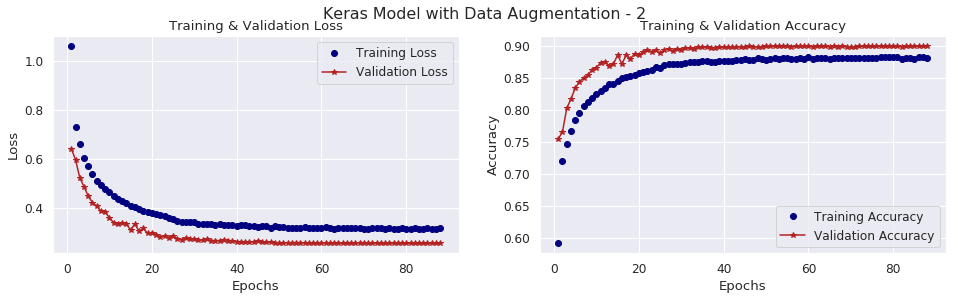


Evaluating...
Training data:
60000/60000 [==============================] - 7s 122us/step
  Training : loss 0.228 - acc 0.913
Cross-validation data:
8000/8000 [==============================] - 1s 112us/step
  Cross-val: loss 0.253 - acc 0.900
Saved model to files /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_aug.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_aug.h5


In [0]:
# let us use an even more lenient callbacks list
def lr_scheduler(epoch, lr):
    # after every 50th epoch, reduce lr by factor of 10
    if epoch == 0:
        print('Starting with learning rate: %.6f' % lr, flush=True)
    elif (epoch > 0) and (epoch % 25 == 0):
        lr /= 5
        print('Changing learning rate to: %.6f' % lr, flush=True)
    return lr

from keras.callbacks import LearningRateScheduler, EarlyStopping

callbacks_list3 = [
    LearningRateScheduler(
        lr_scheduler,
        verbose=0    # update messages
    ),
    # Early stop training if val_acc falls or stays flat for 7 epochs
    EarlyStopping(
        monitor='val_acc',
        min_delta=0.00001,
        patience=20        
    ),
]


plot_title = 'Keras Model with Data Augmentation - 2'
model_name = 'kr_fashion_cnn_aug'
# this will take a long time to run - intractible on CPU. Run with GPU, like one offered by Google Colab
train_and_evaluate_model_aug(model, X_train, y_train, X_val, y_val,
                         num_epochs=250, batch_size=32, callbacks=callbacks_list3,
                         plot_title=plot_title, model_save_name=model_name)

Loaded model from files /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_aug.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_fashion_cnn_aug.h5
Evaluating against test data...
2000/2000 [==============================] - 1s 451us/step
  - Test data: loss 0.271 - acc 0.902
Displaying sample predictions...


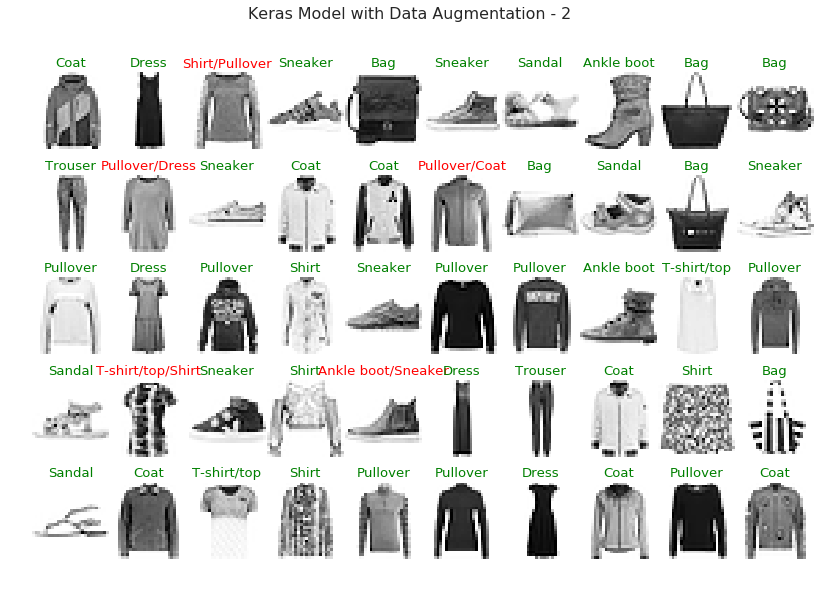

In [0]:
do_predictions('kr_fashion_cnn_aug', X_test, y_test, test_images, test_labels, plot_title=plot_title)

**Observations & Conclusion:**<br/>
See [this Colab Notebook](https://colab.research.google.com/drive/1brSHFOnPQTo0-9vQRC6oslZjAGRbzWuY) for _examples on inserting tables inside markdown cells_
>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|98-99%|92-93%|92-93%
>**Base Model + L2 Reg**|95-96%|92-93%|92-93%
>**Base Model + Dropout Reg**|96-97%|93-94%|93-94%
>**Base Model + L2 Reg + Dropout Reg (0.0015)**|92-93%|90-91%|90-91%
>**Base Model + L2 Reg + Dropout Reg - 2 (0.0045)**|94-95%|92-93%|91-92%
>**Base Model + Dropout Reg + Image Aug**|91-92%|90-91%|90-91%

* **Conclusion:** 
* Using image augmentation with model with dropout gives us more realistic results - the model is not overfitting the data (difference between training & cross-validation accuracies is minimal).
* From the plots it appears that this model is in-fact _under-fitting_ the data - it's cross-validation & test accuracies are mostly above training accuracies.
* For the increased training data, our model architecture lands up being a bit too simple to detect all the variations. We will need a more complex architecture (more layers, more nodes per layer etc.) to get better performance using Image Augmentation.

## Summary
* In this notebook we developed a CNN for classifying the Fashion-MNIST dataset
* We ran a base-model on training data and found that it overfit extremely - since we got training accuracy of 99-100%
* To address the overfitting, we tried sevral options - L2 regularization, dropout regularization and a combination. We found that they reduce overfitting to various degrees. In our case, we got the best performance with a model that used just dropout regularization.
* As a final test, we used the model with dropout regularization with Image Augmentation. Image Augmentation artifically increases the amount of training data available to the model by implementing several random transformations, like shearing, zooming etc. We noticed that we got a more realistic performance metric from this technique - training accuracy = ??, cross-validation acc = ?? and test accuracy = ??
* In conclusion, we can say that there are several techniques of addressing overfitting. There is no best way that works for all models - we should try several options to get the best results. However, it is best to try with image augmentation at the very outset, so we get more realistic performance metrics that can be addressed with regularization.
* **NOTE:** In the Github repository look for file `Fashion-CNN-Keras-2.ipynb`.  I have used a similar approach as shown in this notebook, but training uses Image Augmentation from the very beginning so we get more realistic results from the model.

# <center> - - END - - </center>